Parameters and first configurations

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# PyTorch
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining network
from torchsummary import summary
# Timing utility
from timeit import default_timer as timer

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
!curl http://weegee.vision.ucmerced.edu/datasets/UCMerced_LandUse.zip -o ucm
!unzip ucm
!rm ucm
!mkdir data
!mv UCmerced_LandUse/images data/
!rm -rf UCmerced_LandUse
!rmdir data

In [ ]:
!mkdir /content/UCMerced_LandUse/train
!mkdir /content/UCMerced_LandUse/test

In [ ]:
# Caminho para a pasta que contém as subpastas de classes com as imagens
images_dir = "/content/UCMerced_LandUse/Images"

# Caminhos para as pastas de destino
train_dir = "/content/UCMerced_LandUse/train"
test_dir = "/content/UCMerced_LandUse/test"

save_file_name = 'vgg16-transfer-4.pt'
checkpoint_path = 'vgg16-transfer-4.pth'

# Change to fit hardware
batch_size = 21

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')

Train on gpu: False


In [ ]:
import os
import glob
import shutil
from sklearn.model_selection import train_test_split

data_paths = []
labels = []

# Iterating over class subfolders
for label in os.listdir(images_dir):
    class_dir = os.path.join(images_dir, label)  # Directory path

    if os.path.isdir(class_dir):
        files = [f for f in os.listdir(class_dir) if f.endswith('.tif')]
        file_paths = [os.path.join(class_dir, f) for f in files]

        data_paths.extend(file_paths)
        labels.extend([label] * len(files))

# Division of data into training and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(data_paths, labels, test_size=0.2, random_state=42, stratify=labels)

def move_files(paths, labels, dest_dir):
    for path, label in zip(paths, labels):
        dest_class_dir = os.path.join(dest_dir, label)
        os.makedirs(dest_class_dir, exist_ok=True)  # Creates the class folder if it doesn't exist
        shutil.copy2(path, dest_class_dir)

# Moving the training and testing files to the proper folder
move_files(train_paths, train_labels, train_dir)
move_files(test_paths, test_labels, test_dir)

print("Division complete!")

In [ ]:
# Empty lists
categories = []
img_categories = []
n_train = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(train_dir):
    categories.append(d)

    # Number of each image
    train_imgs = os.listdir(os.path.join(train_dir, d))
    test_imgs = os.listdir(os.path.join(test_dir, d))
    n_train.append(len(train_imgs))
    n_test.append(len(test_imgs))

    # Find stats for train images
    for i in train_imgs:
        img_categories.append(d)
        img_path = os.path.join(train_dir, d, i)
        img = Image.open(img_path)
        img_array = np.array(img)
        # Shape
        hs.append(img_array.shape[0])
        ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories, 'n_train': n_train, 'n_test': n_test}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.head()


In [ ]:
img_dsc = image_df.groupby('category').describe()
img_dsc.head()

Image Preprocessing

In [ ]:
# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=200, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=30),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=64),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Test does not use augmentation
    'test':
    transforms.Compose([
        transforms.Resize(size=64),
        transforms.CenterCrop(size=180),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'test':
    datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}

# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [ ]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([21, 3, 64, 64]), torch.Size([21]))

In [ ]:
n_classes = len(cat_df)
print(f'There are {n_classes} different classes.')

len(data['train'].classes)

Starting the pre-trained model

In [ ]:
model = models.vgg16(pretrained=True)
model

In [ ]:
# Freeze early layers
for param in model.parameters():
    param.requires_grad = False

In [ ]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

model.classifier

In [ ]:
# To check the number of parameters, in principle, none for the test with pretrained=False

total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')


In [ ]:
# Choose CPU or GPU

if train_on_gpu:
  model = model.to('cuda')
else:
  model = model.to('cpu')

In [ ]:
def get_pretrained_model(model_name):

    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, n_classes), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    if train_on_gpu:
        model = model.to('cuda')

    return model

In [ ]:
model = get_pretrained_model('vgg16')
summary(model, input_size=(3, 224, 224), batch_size=batch_size, device='cuda')

In [ ]:
# Replace output layer for 21 class classifier

model.classifier[6] = nn.Linear(in_features=4096, out_features=21)

In [ ]:
model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())[:21]

In [ ]:
# Defrosting FC

for name, child in model.named_children():
    if name == 'classifier':
        for param in child.parameters():
            param.requires_grad = True
    else:
        for param in child.parameters():   # Full freeze
            param.requires_grad = False


Training

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
for p in optimizer.param_groups[0]['params']:
    if p.requires_grad:
        print(p.shape)

In [ ]:
import torch
import numpy as np
import pandas as pd
from timeit import default_timer as timer

def train(model, criterion, optimizer, train_loader, save_file_name, n_epochs, print_every=1):

    history = [] # Used for the pretrained=False
    history2 = []
    model.epochs = 0
    overall_start = timer()

    # Main training loop
    for epoch in range(n_epochs):
        train_loss = 0.0
        train_acc = 0

        # Set model to training mode
        model.train()
        start = timer()

        # Iterate over training data
        for data, target in train_loader:
            # Move tensors to GPU if available
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(data)
            loss = criterion(output, target)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Track loss
            train_loss += loss.item() * data.size(0)
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            train_acc += accuracy.item() * data.size(0)

        # Calculate average losses and accuracy
        train_loss = train_loss / len(train_loader.dataset)
        train_acc = train_acc / len(train_loader.dataset)
        history.append([train_loss, train_acc])
        history2.append([train_loss, train_acc])

        # Print training progress
        if (epoch + 1) % print_every == 0:
            print(f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.1f} \tTraining Accuracy: {100 * train_acc:.2f}%')
            print(f'{timer() - start:.2f} seconds elapsed in epoch.')

    # Save final model
    torch.save(model.state_dict(), save_file_name)
    total_time = timer() - overall_start
    print(f'\nTotal training time: {total_time:.2f} seconds')

    # Format history
    history = pd.DataFrame(history, columns=['train_loss', 'train_acc'])
    history2 = pd.DataFrame(history2, columns=['train_loss', 'train_acc'])
    return model, history2


In [ ]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()



Epoch: 0 	Training Loss: 3.0 	Training Accuracy: 5.18%
120.65 seconds elapsed in epoch.

Epoch: 1 	Training Loss: 3.0 	Training Accuracy: 4.46%
119.10 seconds elapsed in epoch.

Epoch: 2 	Training Loss: 3.0 	Training Accuracy: 5.30%
120.08 seconds elapsed in epoch.

Epoch: 3 	Training Loss: 3.0 	Training Accuracy: 7.98%
119.89 seconds elapsed in epoch.

Epoch: 4 	Training Loss: 2.9 	Training Accuracy: 9.46%
118.52 seconds elapsed in epoch.

Epoch: 5 	Training Loss: 2.9 	Training Accuracy: 10.83%
121.41 seconds elapsed in epoch.

Epoch: 6 	Training Loss: 2.9 	Training Accuracy: 11.73%
117.11 seconds elapsed in epoch.

Epoch: 7 	Training Loss: 2.8 	Training Accuracy: 13.04%
119.89 seconds elapsed in epoch.

Epoch: 8 	Training Loss: 2.8 	Training Accuracy: 12.74%
122.23 seconds elapsed in epoch.

Epoch: 9 	Training Loss: 2.8 	Training Accuracy: 13.81%
120.87 seconds elapsed in epoch.

Total training time: 1201.74 seconds


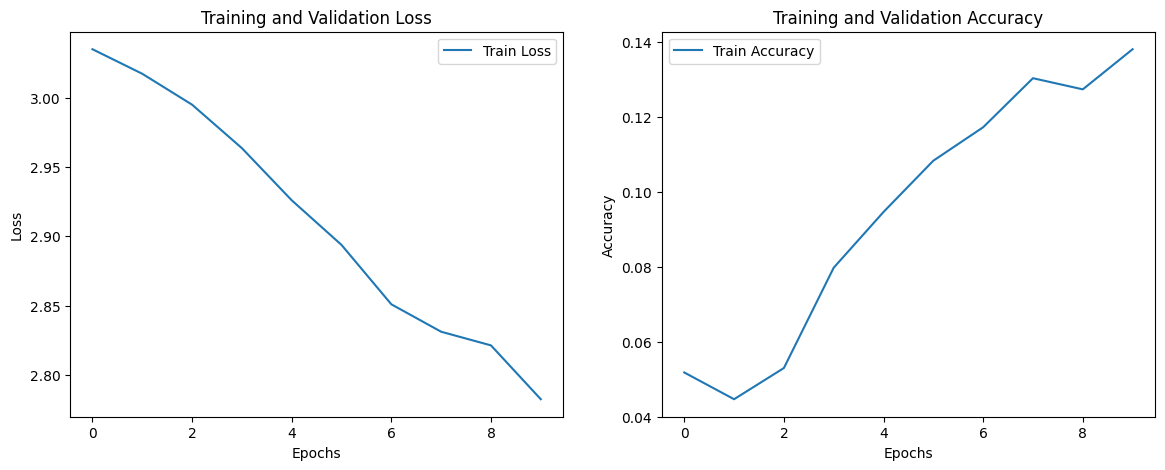

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    save_file_name=save_file_name,
    n_epochs=10,
    print_every=1)

plot_history(history)

Sobre os gráficos acima, segue o treino com 10 épocas. Na esquerda, é possível perceber que a perca sempre diminuiu, o que era o esperado, já na direita, apesar de ter tido uma leve queda seguida de aumentos, a acurácia aumentou ao longo do treinamento, assim como deveria ser.

Como resultado final, a perda chegou a 2.8 e a acurácia a 13.81%, o que é um resultado bem baixo, porém com o gráfico correspondendo a tendência certa de crescimento.


Epoch: 0 	Training Loss: 2.5 	Training Accuracy: 44.05%
292.88 seconds elapsed in epoch.

Epoch: 1 	Training Loss: 1.9 	Training Accuracy: 58.33%
284.27 seconds elapsed in epoch.

Epoch: 2 	Training Loss: 2.2 	Training Accuracy: 58.93%
277.25 seconds elapsed in epoch.

Epoch: 3 	Training Loss: 2.2 	Training Accuracy: 60.12%
273.02 seconds elapsed in epoch.

Epoch: 4 	Training Loss: 2.2 	Training Accuracy: 61.79%
267.68 seconds elapsed in epoch.

Epoch: 5 	Training Loss: 2.1 	Training Accuracy: 63.39%
270.83 seconds elapsed in epoch.

Epoch: 6 	Training Loss: 2.0 	Training Accuracy: 64.58%
263.94 seconds elapsed in epoch.

Epoch: 7 	Training Loss: 2.0 	Training Accuracy: 65.89%
267.26 seconds elapsed in epoch.

Epoch: 8 	Training Loss: 1.8 	Training Accuracy: 62.62%
311.14 seconds elapsed in epoch.

Epoch: 9 	Training Loss: 1.9 	Training Accuracy: 65.65%
351.80 seconds elapsed in epoch.

Total training time: 2861.66 seconds


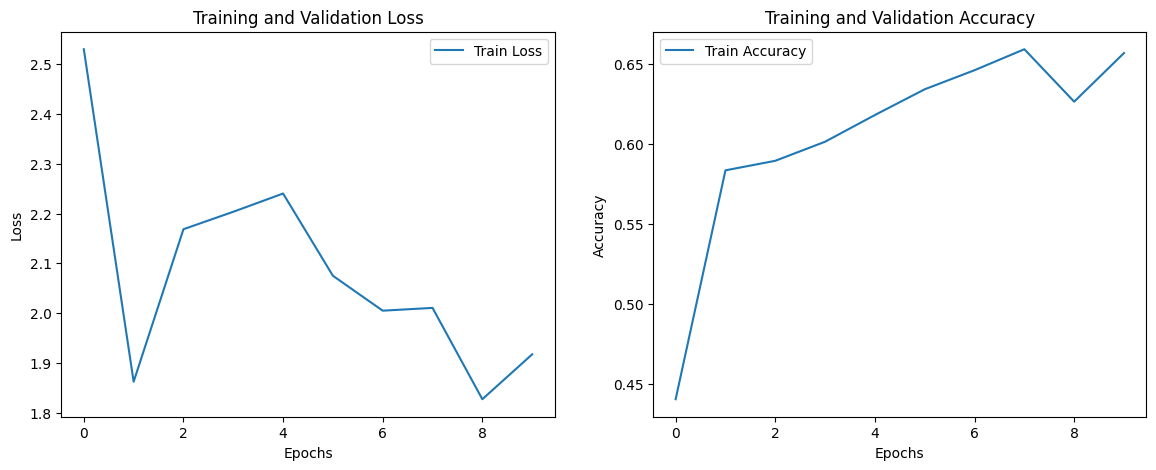

In [ ]:
model, history2 = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    save_file_name=save_file_name,
    n_epochs=10,
    print_every=1)

plot_history(history2)

Já sobre esses outros, também com 10 épocas, a estrutura dos gráficos ficou um pouco diferenciada.
Para a perda, o modelo mostrou uma rápida queda, passando de 2.5 para 1.9 e depois disso oscilou bastante, não sendo exatamente o que era o esperado. Mas no da acurácia, o modelo teve um bom rendimeto, mostrando um gráfico crescente (com uma pequena oscilção) mas que finalizou com um resultado bastante bom, crescendo mais de 20%.

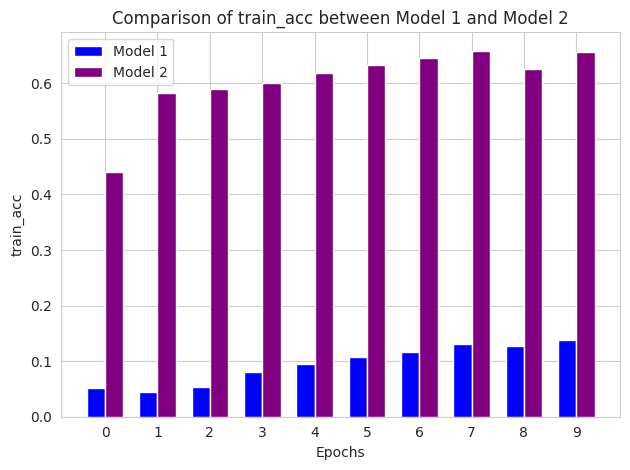

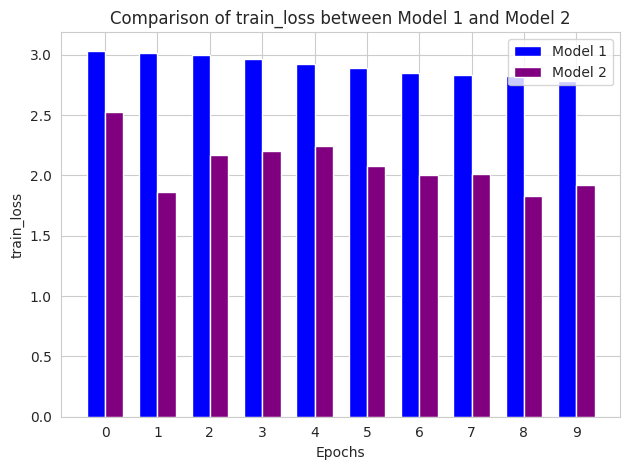

In [ ]:

def plot_comparison(history, history2, metric):
    bar_width = 0.35

    index = np.arange(len(history))

    plt.bar(index, history[metric], bar_width, label='Model 1', color='blue')
    plt.bar(index + bar_width, history2[metric], bar_width, label='Model 2', color='purple')

    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.title(f'Comparison of {metric} between Model 1 and Model 2')
    plt.xticks(index + bar_width / 2, range(len(history)))
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_comparison(history, history2, 'train_acc')
plot_comparison(history, history2, 'train_loss')

Como é possível observar acima, a perda foi bem menor no segundo modelo e a acurácia extremamente maior, o que me leva a concluir que o segundo modelo, com somente a camada Fully-Conected descolgelada é o melhor dentre os analisados.

Obs: Não consegui fazer o teste com o terceiro modelo, então a conclusão leva em consideração somente os dois primeiros.